# Interactive simplicial filtrations
This notebook generates and interactively plots the following filtered simplicial complexes and their persistence diagrams:

* Delaunay complexes
* Cech complexes
* Rips complexes.

Please make sure do have all packages installed to run the following:

In [10]:
import matplotlib, matplotlib.pyplot as plt, matplotlib.collections
from matplotlib.collections import LineCollection, EllipseCollection, PatchCollection
import numpy as np, scipy as sp, gudhi, ripser, smallestenclosingcircle
from ipywidgets import interact, interactive, fixed, interact_manual
from math import floor, ceil, sqrt
from itertools import combinations
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
%matplotlib widget

In [3]:
matplotlib.rcParams.update({'text.usetex': False})
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'pgf.preamble': r'\usepackage{sansmath}\sansmath',
    'font.size': 9,
    'text.latex.preamble': r'\usepackage{sansmath}\sansmath',
    'lines.markersize': sqrt(8),
    # 'font.family': "Noto Sans"
})


# Sample
Generate a sample from a sphere.

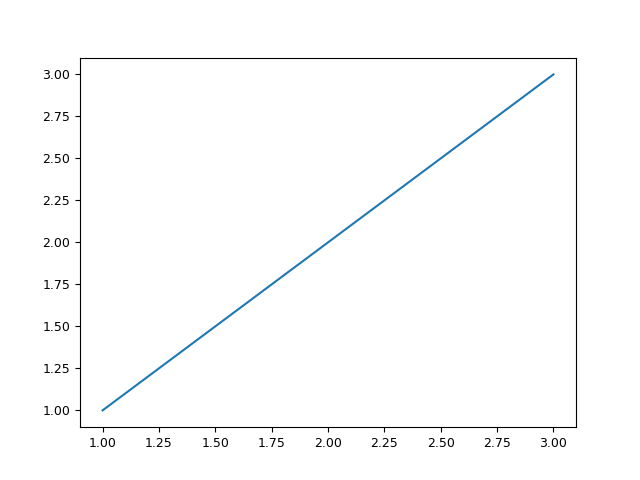

In [4]:
plt.figure()
plt.plot([1,2,3],[1,2,3])

In [36]:
def sphere_sample(sample_size, ambient_dimension, vertical_noise=0):
    ''' Uniform point sample on a unit sphere with chi^2-distributed vertical offset. '''
    points = np.zeros((0, ambient_dimension))
    while points.shape[0] < sample_size:
        new_sample_size = sample_size-points.shape[0]
        new_points = np.random.random_sample(size=(new_sample_size, ambient_dimension)) * 2 - 1
        norms      = np.linalg.norm(new_points, axis=1)
        selection  = norms > 0.1
        points     = np.vstack((points, new_points[selection,:] / norms[selection, None]))
    noise = np.random.normal(0, vertical_noise, sample_size)
    points = (1 + noise[:, None]) * points
    return points

def two_spheres(sample_size, ambient_dimension, vertical_noise=0, *, diam1=1, diam2 = 1):
    return np.vstack((
        diam1 * (sphere_sample(sample_size, ambient_dimension, vertical_noise) - np.hstack(([1], np.full(ambient_dimension-1, 0)))),
        diam2 * (sphere_sample(sample_size, ambient_dimension, vertical_noise) + np.hstack(([1], np.full(ambient_dimension-1, 0)))),
    ))

def snowman(sample_size, ambient_dimension, vertical_noise=0, *, diam1=.5, diam2 = 1):
    data = np.vstack((
        diam1 * (sphere_sample(sample_size, ambient_dimension, vertical_noise) - np.hstack(([1], np.full(ambient_dimension-1, 0)))),
        diam2 * (sphere_sample(sample_size, ambient_dimension, vertical_noise) + np.hstack(([1], np.full(ambient_dimension-1, 0)))),
    ))
    data = data[np.linalg.norm(data,axis=1) > .25,:]
    if len(data) < sample_size:
        return np.vstack((data, snowman(sample_size - len(data), ambient_dimension, vertical_noise, diam1=diam1, diam2=diam2)))
    else:
        return data
    
data = sphere_sample(n := 100, 2, 0.4) #* np.array([[2,1]])
data = snowman(n := 100, 2, 0.1)

In [38]:
data = np.loadtxt("/homes/combi/lenzen/TUM-Nextcloud/Dokumente/Uni/Eigene Vorträge/2025-10 DMG Seminar/pictures/1D-example/data.txt")

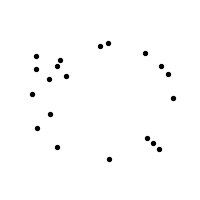

In [40]:
plt.figure(figsize=(2,2))
plt.gca().set_aspect('equal')
plt.gca().axis('off')
plt.scatter(*data.T, c='black', s=8)

## Adding outliers
If you want outliers, run the following:

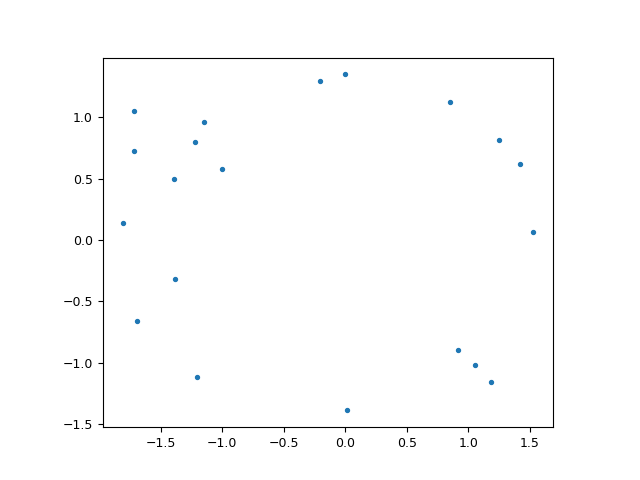

In [34]:
def disc(sample_size, ambient_dimension):
    ''' Uniform point sample on a unit disc/ball. '''
    points = np.zeros((0, ambient_dimension))
    while points.shape[0] < sample_size:
        new_sample_size = sample_size-points.shape[0]
        new_points = np.random.random_sample(size=(new_sample_size, ambient_dimension)) * 2 - 1
        norms      = np.linalg.norm(new_points, axis=1)
        selection  = norms < 1
        points     = np.vstack((points, new_points[selection,:]))
    return points

# Filtrations
## Delaunay filtration
Generate Delaunay filtration

In [41]:
# Use Gudhi to compute the Delaunay (or alpha-)filtration
cplx = gudhi.AlphaComplex(data)
simplex_tree = cplx.create_simplex_tree()
filtration = list(simplex_tree.get_filtration())
triangles, tri_diameters = map(np.array, list(zip(*[(s, r) for s, r in filtration if len(s) == 3])))
edges, edge_diameters = map(np.array, list(zip(*[(s, r) for s, r in filtration if len(s) == 2])))

# Take square roots; Gudhi works with alpha**2.
tri_diameters = np.sqrt(tri_diameters)
edge_diameters = np.sqrt(edge_diameters)
dims, pairs = map(np.array, zip(*simplex_tree.persistence()))
diagrams = [np.sqrt(pairs[dims==d]) for d in range(np.max(dims)+1)]

Probably, we want this for plots:

In [42]:
def circumradius(T):
    (x1, y1), (x2, y2), (x3, y3) = T
    A = np.array([[x3-x1,y3-y1],[x3-x2,y3-y2]])
    Y = np.array([(x3**2 + y3**2 - x1**2 - y1**2),(x3**2+y3**2 - x2**2-y2**2)])
    if np.linalg.det(A) == 0:
        return False
    Ainv = np.linalg.inv(A)
    X = 0.5*np.dot(Ainv,Y)
    x,y = X[0],X[1]
    r = np.sqrt((x-x1)**2+(y-y1)**2)
    return (x, y), r

## Rips complex
To generate Rips complex, run the following instead:

In [23]:
edges = np.array(list(combinations(range(len(data)), 2)))
edge_diameters = np.linalg.norm(data[edges[:,0]] - data[edges[:,1]], axis=-1)/2
triangles = np.array(list(combinations(range(len(data)), 3)))
tri_diameters = np.max(np.column_stack((
    np.linalg.norm(data[triangles[:,0]]-data[triangles[:,1]], axis=-1),
    np.linalg.norm(data[triangles[:,0]]-data[triangles[:,2]], axis=-1),
    np.linalg.norm(data[triangles[:,1]]-data[triangles[:,2]], axis=-1)
)), -1)/2
import ripser
diagrams = ripser.ripser(data)['dgms']

## Cech complex
To generate Cech complex, run the following instead:

In [ ]:
edges = np.array(list(combinations(range(len(data)), 2)))
edge_diameters = np.linalg.norm(data[edges[:,0]] - data[edges[:,1]], axis=-1)/2
triangles = np.array(list(combinations(range(len(data)), 3)))
tri_diameters = np.array([smallestenclosingcircle.make_circle(data[T])[2] for T in triangles])

# Plots

interactive(children=(FloatSlider(value=0.0, description='r', max=1.3723238589535431, step=0.05), Output()), _…

<function __main__.update(r)>

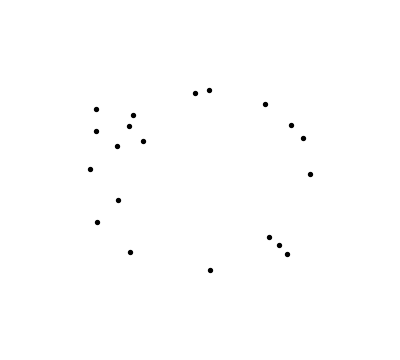

In [55]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'text.usetex': False,
    'font.family': 'sans-serif',
})

# Generate a new plot of fixed width 4 and with the necessary height to accomodate plot.
inf_val = max(np.max(dgm[dgm != np.inf]) for dgm in diagrams)*1.1
aspect = ((np.min(data[:,0])-inf_val) - (np.max(data[:,0])+inf_val)) / ((np.min(data[:,1])-inf_val) - (np.max(data[:,1])+inf_val))
fig = plt.figure(figsize=(4,4/aspect))
fig.set_layout_engine('tight', pad=0)
ax1 = fig.gca()
ax1.set_aspect('equal')
ax1.set_axis_off()
# ax1.margins(0)

ax1.set_xlim(np.min(data[:,0])-inf_val, np.max(data[:,0])+inf_val)
ax1.set_ylim(np.min(data[:,1])-inf_val, np.max(data[:,1])+inf_val)
ax1.set_xticks([])
ax1.set_yticks([])

cmap = matplotlib.colors.ListedColormap("#FFFFFFA0")

r = 0
ax1.scatter(*data.T, color="black", s=8, zorder=2)
p_circles       = [ax1.add_patch(plt.Circle(p, 0, alpha=0.4)) for p in data]
p_circumcircles = None#[ax1.add_patch(plt.Circle(*circumradius(data[t]), color="none", ec="black", lw=0.5)) for t in triangles]
p_tris = None
p_edges = None

def update(r):
    for c in p_circles:
        c.set_radius(r)
    global p_tris, p_edges
    if p_tris is not None: p_tris.remove()
    if p_edges is not None: p_edges.remove()
    p_tris = ax1.tripcolor(*data.T, triangles[tri_diameters <= r], np.full(np.count_nonzero(tri_diameters <= r), 0), alpha=None, cmap=cmap, ec=None) if np.min(tri_diameters) <= r else None
    p_edges = ax1.add_collection(LineCollection(data[edges[edge_diameters <= r]], lw=1, color='black'))
    if p_circumcircles is not None:
        for c, diam in zip(p_circumcircles, tri_diameters):
            c.set_visible(diam <= r)
    
interact(update, r=FloatSlider(min=0, max=inf_val, step=0.05, value=0, description='r'))


# Persistence diagram

/tmp/ipykernel_14143/56766761.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='lower right', frameon=False, handletextpad=-0.5, alignment='left', borderpad=0)


interactive(children=(FloatSlider(value=0.0, description='r', max=1.3723238589535431, step=0.05), Output()), _…

<function __main__.update(r)>

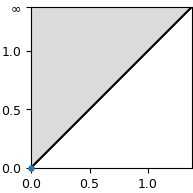

In [54]:
w = 418 / 72 / 3
fig = plt.figure(figsize=(w,w))
ax2 = fig.gca()
ax2.set_aspect('equal')
ax2.set_xlim(0, inf_val)
ax2.set_ylim(0, inf_val)
ticks_step=0.5
ticks = np.round(np.arange(inf_val/ticks_step, dtype=int)*ticks_step, decimals=max(ceil(-np.log10(ticks_step)), 0))
ax2.set_yticks(np.append(ticks[:], inf_val))
ax2.set_xticks(ticks[:])
ax2.set_yticklabels(list(ticks[:]) + ["$\infty$"])

# for d, dgm in enumerate(diagrams):
#     ax2.scatter(*np.minimum(dgm, inf_val).T, clip_on=False, zorder=20, label=f"$H_{d}$")

ax2.plot((0,inf_val), (0,inf_val), 'black', lw=1)
ax2.legend(loc='lower right', frameon=False, handletextpad=-0.5, alignment='left', borderpad=0)
fig.tight_layout(pad=0.15)

ax2.plot([0,inf_val], [0,inf_val], c='black')
pers_plots = [ax2.scatter(*np.minimum(dgm, inf_val).T, clip_on=False, label=f"$H_{d}$", zorder=20) for d, dgm in enumerate(diagrams)]
pers_poly = ax2.add_patch(plt.Polygon([(0, 0), (inf_val, inf_val), (0, inf_val), (0, 0)], fc="gainsboro"))


def update(r):
    # UPDATE PERSISTENCE DIAGRAM
    for p, dgm in zip(pers_plots, diagrams):
        p.set_offsets(np.minimum(dgm[dgm[:,0] <= r], r))
    pers_poly.set_xy([(r, r), (inf_val, inf_val), (0, inf_val), (0, r)])
    
    
interact(update, r=FloatSlider(min=0, max=inf_val, step=0.05, value=0, description='r'))


# Together

interactive(children=(FloatSlider(value=0.0, description='r', max=1.3723238589535431, step=0.05), Output()), _…

<function __main__.update(r)>

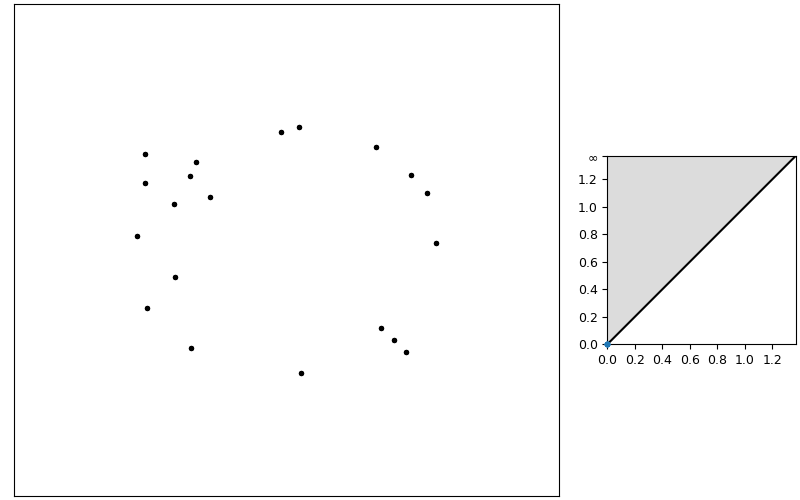

In [52]:
inf_val = max(np.max(dgm[dgm != np.inf]) for dgm in diagrams)*1.1
w, h = 8,5
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(w, h), width_ratios=[3,1], constrained_layout=True)

ax1.set_aspect('equal')
ax1.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax1.set_xlim(np.min(data[:,0])-inf_val, np.max(data[:,0])+inf_val)
ax1.set_ylim(np.min(data[:,1])-inf_val, np.max(data[:,1])+inf_val)
ax2.set_aspect('equal')
ax2.set_xlim(0, inf_val)
ax2.set_ylim(0, inf_val)
ticks_step=0.2
ticks = np.round(np.arange(inf_val/ticks_step, dtype=int)*ticks_step, decimals=max(ceil(-np.log10(ticks_step)), 0))
ax2.set_yticks(np.append(ticks[:], inf_val))
ax2.set_xticks(ticks[:])
ax2.set_yticklabels(list(ticks[:]) + ["$\infty$"])

ax1.scatter(*data.T, color="black", zorder=2)
p_circles       = [ax1.add_patch(plt.Circle(p, 0, alpha=0.3)) for p in data]

cmap = matplotlib.colors.ListedColormap("#FFFFFFA0")

r = 0
ax1.scatter(*data.T, color="black", s=8, zorder=2)
p_circles = [ax1.add_patch(plt.Circle(p, 0, alpha=0.4)) for p in data]
p_circumcircles = None #[ax1.add_patch(plt.Circle(*circumradius(data[t]), color="none", ec="black", lw=0.5)) for t in triangles]
p_tris = None
p_edges = None

ax2.plot([0,inf_val], [0,inf_val], c='black')
pers_plots = [ax2.scatter(*np.minimum(dgm, inf_val).T, clip_on=False, label=f"$H_{d}$", zorder=20) for d, dgm in enumerate(diagrams)]
pers_poly = ax2.add_patch(plt.Polygon([(0, 0), (inf_val, inf_val), (0, inf_val), (0, 0)], fc="gainsboro"))

def update(r):
    # UPDATE COMPLEX       
    for c in p_circles:
        c.set_radius(r)
    if p_circumcircles is not None:
        for c, diam in zip(p_circumcircles, tri_diameters):
            c.set_visible(diam <= r)
    global p_tris, p_edges
    if p_tris is not None: p_tris.remove()
    if p_edges is not None: p_edges.remove()
    p_tris = ax1.tripcolor(*data.T, triangles[tri_diameters <= r], np.full(np.count_nonzero(tri_diameters <= r), 0), alpha=None, cmap=cmap, ec=None) if np.min(tri_diameters) <= r else None
    p_edges = ax1.add_collection(LineCollection(data[edges[edge_diameters <= r]], lw=1, color='black'))

    # UPDATE PERSISTENCE DIAGRAM
    for p, dgm in zip(pers_plots, diagrams):
        p.set_offsets(np.minimum(dgm[dgm[:,0] <= r], r))
    pers_poly.set_xy([(r, r), (inf_val, inf_val), (0, inf_val), (0, r)])
    
    
interact(update, r=FloatSlider(min=0, max=inf_val, step=0.05, value=0, description='r'))


# Stability

In the following, we create `N` point clounds, drawn from the same distribution:

/tmp/ipykernel_14143/4143901292.py:28: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


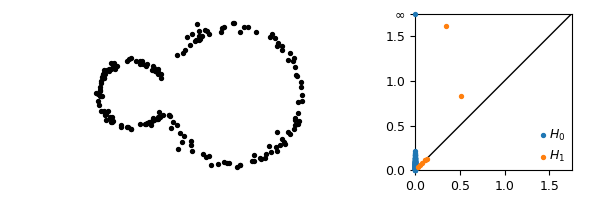

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2), width_ratios=[2,1], constrained_layout=True)
N = 100
inf_val = 1.75

np.random.seed(seed=1)
data = snowman(N, 2, 0.05)
diagrams = ripser.ripser(data)['dgms']

# Prepare the area for the points
ax1.set_aspect('equal')
ax1.axis('off')
s1 = ax1.scatter(*data.T, c='black')
# Prepare area for persistence diagrams
ax2.set_aspect('equal')
ax2.set_xlim(0, inf_val)
ax2.set_ylim(0, inf_val)
ticks_step=0.5
ticks = np.round(np.arange(inf_val/ticks_step, dtype=int)*ticks_step, decimals=max(ceil(-np.log10(ticks_step)), 0))
ax2.set_yticks(np.append(ticks[:], inf_val))
ax2.set_xticks(ticks[:])
ax2.set_yticklabels(list(ticks[:]) + ["$\infty$"])
ax2.plot((0,inf_val), (0,inf_val), 'black', lw=1)
s2 = [ax2.scatter(*dgm.T, clip_on=False, zorder=20, label=f"$H_{d}$") for d, dgm in enumerate(diagrams)]
ax2.legend(loc='lower right', frameon=False, handletextpad=-0.5, alignment='left', borderpad=0)
# Collect the diagrams for later analysis
all_diagrams = []
# Create an animation
fig.tight_layout()
def update(i):
    data = snowman(N, 2, 0.05)
    diagrams = ripser.ripser(data)['dgms']
    s1.set_offsets(data)
    for s, dgm in zip(s2, diagrams):
        s.set_offsets(np.minimum(dgm, inf_val))
    all_diagrams.append(diagrams)
    # fig.savefig(f"pictures/frame_{i:03d}.pdf", transparent=True, dpi=300)
from matplotlib.animation import FuncAnimation
# animation = FuncAnimation(fig, update, interval=10, frames=200, repeat=False)
# plt.show()

from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('multipage.pdf') as pdf:
    for i in range(200):
        update(i)
        pdf.savefig(fig, transparent=True, dpi=300)

Let's see how the most prominent classes distribute.

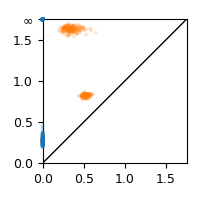

In [8]:
fig = plt.figure(figsize=(2,2))
ax2 = fig.gca()
ax2.set_aspect('equal')
ax2.set_xlim(0, inf_val)
ax2.set_ylim(0, inf_val)
ticks_step=0.5
ticks = np.round(np.arange(inf_val/ticks_step, dtype=int)*ticks_step, decimals=max(ceil(-np.log10(ticks_step)), 0))
ax2.set_yticks(np.append(ticks[:], inf_val))
ax2.set_xticks(ticks[:])
ax2.set_yticklabels(list(ticks[:]) + ["$\infty$"])
ax2.plot((0,inf_val), (0,inf_val), 'black', lw=1)

for i in range(0,2):
    pts = np.vstack([diagram[i][np.argsort(np.diff(diagram[i], axis=1)[:,0])[-2::],:] for diagram in all_diagrams])
    ax2.scatter(*np.minimum(pts, inf_val).T, clip_on=False, zorder=20, alpha=.2, edgecolor='none')
fig.tight_layout()
fig.savefig("pictures/top_classes.pdf", transparent=True, dpi=300)

To confirm this further, compute all bottleneck distances. The pairwise distances should be $\chi^2$-distributed:

(2.316084149438084, 0.007520398981545374, 0.0359233149940827)

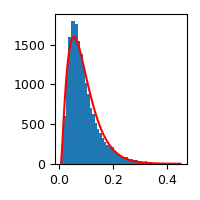

In [12]:
all_distances = [gudhi.bottleneck_distance(diagrams1[1], diagrams2[1]) 
                 for i, diagrams1 in enumerate(all_diagrams)
                 for    diagrams2 in all_diagrams[i+1:]]
fig = plt.figure(figsize=(2,2))
ax = fig.gca()
n, bins, _ = ax.hist(all_distances, bins=50)
bin_centers = bins[:-1] + .5*np.diff(bins)
fit_params = sp.stats.gamma.fit(all_distances, 3, loc=bin_centers[np.argmax(n)])
x = np.linspace(bins[0], bins[-1], 2*len(bins))
ax.plot(x, sp.stats.gamma.pdf(x, *fit_params) * np.dot(n, np.diff(bins)), c='red')
fig.tight_layout()
fig.savefig("pictures/pairwise_bottleneck_distances.pdf", transparent=True, dpi=300)
fit_params